# Alphas, betas and regressions refactoring with classes

Vamos a refectorizar, y veremos porqué lo hacemos con funciones o con clases. Las dos son buenas soluciones pero dependiendo de lo que estamos haciendo nos servirá mejor una cosa u otra. Cada solución responde a una cierta problematica y en particular tenemos que ver qué cosas estamos haciendo de manera que después las debamos utilizar. 

* `funciones` : las utilizo cuando se que estoy haciendo un proceso independiente y que eventualmente voy a reutilizar.
* `clases` : y si cosas que dependen de ciertos procesos particulares prefiero esconderlo con clases porque la encapsulación en mucho más precisa.

Este era el código que teníamos:

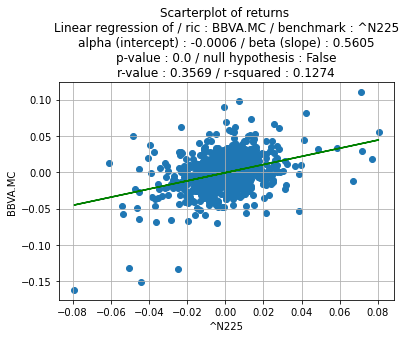

In [1]:
import numpy as np
import pandas as pd
import scipy
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import skew, kurtosis, chi2, linregress
# our own files an reload
import stream_04_classes_refactoring2
import stream_functions
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


# BBVA.MC vs Nikkei 225 (^N225)
ric = "BBVA.MC"
benchmark = "^N225"
file_extension = "csv"
nb_decimals = 4

# ric = r_a & benchmark = r_m
x1, str1, t1 = stream_functions.load_time_series(ric)
x2, str2, t2 = stream_functions.load_time_series(benchmark)

# sinchronize timestamps
timestamps1 = list(t1['date'].values) # .values lo convierte en array
timestamps2 = list(t2['date'].values)
timestamps = list(set(timestamps1) & set(timestamps2))

# synchronised time series for x1 (ric)
t1_sync = t1[t1['date'].isin(timestamps)]
t1_sync.sort_values(by='date', ascending=True)
t1_sync = t1_sync.reset_index(drop=True)

# synchronised time series for x2 (benchmark)
t2_sync = t2[t2['date'].isin(timestamps)]
t2_sync.sort_values(by='date', ascending=True)
t2_sync = t2_sync.reset_index(drop=True)

# table of returns for ric and benchmark
t = pd.DataFrame()
t['date'] = t1_sync.date
t['price_1'] = t1_sync.close
t['price_2'] = t2_sync.close
t['return_1'] = t1_sync.return_close
t['return_2'] = t2_sync.return_close

# compute vectors of return
y = t['return_1'].values
x = t['return_2'].values

# linal regression
slope, intercep, r_values, p_values, std_err = linregress(x, y)

slope = np.round(slope, nb_decimals)
intercept = np.round(intercep, nb_decimals)
p_values = np.round(p_values, nb_decimals)
r_values = np.round(r_values, nb_decimals)
r_squared = np.round(r_values**2, nb_decimals)

# Si el `p_value < 0.05` rechazamos la hipótesis nula.
null_hypothesis = p_values > 0.05

# predictor 
predictor_linreg = slope*x + intercept

# scatterplot of returns
str_title = "Scarterplot of returns " + "\n"\
    + "Linear regression of / ric : " + ric\
    + " / benchmark : " + benchmark + "\n"\
    + "alpha (intercept) : " + str(intercept)\
    + " / beta (slope) : " + str(slope) + "\n"\
    + "p-value : " + str(p_values)\
    + " / null hypothesis : " + str(null_hypothesis) + "\n"\
    + "r-value : " + str(r_values)\
    + " / r-squared : " + str(r_squared)

plt.figure()
plt.title(str_title)
plt.scatter(x,y)
plt.plot(x, predictor_linreg, color="green")
plt.ylabel(ric)
plt.xlabel(benchmark)
plt.grid()
plt.show()

Como sincronizar series de tiempo lo voy a utilizar despues para `matriz de varianza y covarianza`, voy a crear una nueva función que voy a llamar **sinchronise_timeseries()**

In [2]:
def synchronise_timeseries(ric, benchmark, file_extension='csv'):
    """Sincroniza series de tiempo.
    Arguments:
        - ric : value
        - benchmark : market
        - file_extension
    Return:
        - x, y para la regresión
        - t para comprobar resultados
        - file_extension
    """
    # loading data from csv o excel from "stream_functions"
    x1, str1, t1 = stream_functions.load_time_series(ric, file_extension)
    x2, str2, t2 = stream_functions.load_time_series(benchmark, file_extension)

    # sinchronize timestamps
    timestamps1 = list(t1['date'].values)
    timestamps2 = list(t2['date'].values)
    timestamps = list(set(timestamps1) & set(timestamps2))

    # synchronised time series for x1 (ric)
    t1_sync = t1[t1['date'].isin(timestamps)]
    t1_sync.sort_values(by='date', ascending=True)
    t1_sync = t1_sync.reset_index(drop=True)

    # synchronised time series for x2 (benchmark)
    t2_sync = t2[t2['date'].isin(timestamps)]
    t2_sync.sort_values(by='date', ascending=True)
    t2_sync = t2_sync.reset_index(drop=True)

    # table of returns for ric and benchmark
    t = pd.DataFrame()
    t['date'] = t1_sync.date
    t['price_1'] = t1_sync.close
    t['price_2'] = t2_sync.close
    t['return_1'] = t1_sync.return_close
    t['return_2'] = t2_sync.return_close

    # compute vectors of return
    y = t['return_1'].values
    x = t['return_2'].values
 
    return x, y, t

He guardado esta función en mi archivo de funciones `stream_functions.py` 

In [3]:
# reset all variables
%reset -f

Ahora tenemos este código más limpio. Ahora lo que me gustaría es poder tener por la mano el `intercept`, el `p_value`, etc y eliminar variables del código. Entonces me voy a crear una clase que me de todas estas variables.

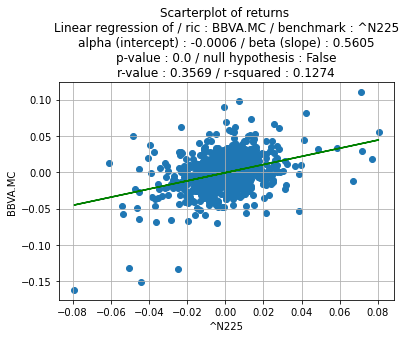

In [4]:
import numpy as np
import pandas as pd
import scipy
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import skew, kurtosis, chi2, linregress
# our own files an reload
import stream_04_classes_refactoring2
import stream_functions
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


ric = "BBVA.MC"
benchmark = "^N225"
file_extension = "csv"
nb_decimals = 4

# return function
x, y, t = stream_functions.synchronise_timeseries(ric, benchmark)

# linal regression
slope, intercep, r_values, p_values, std_err = linregress(x, y)
slope = np.round(slope, nb_decimals)
intercept = np.round(intercep, nb_decimals)
p_values = np.round(p_values, nb_decimals)
r_values = np.round(r_values, nb_decimals)
r_squared = np.round(r_values**2, nb_decimals)
null_hypothesis = p_values > 0.05
predictor_linreg = slope*x + intercept


# scatterplot of returns
str_title = "Scarterplot of returns " + "\n"\
    + "Linear regression of / ric : " + ric\
    + " / benchmark : " + benchmark + "\n"\
    + "alpha (intercept) : " + str(intercept)\
    + " / beta (slope) : " + str(slope) + "\n"\
    + "p-value : " + str(p_values)\
    + " / null hypothesis : " + str(null_hypothesis) + "\n"\
    + "r-value : " + str(r_values)\
    + " / r-squared : " + str(r_squared)


plt.figure()
plt.title(str_title)
plt.scatter(x,y)
plt.plot(x, predictor_linreg, color="green")
plt.ylabel(ric)
plt.xlabel(benchmark)
plt.grid()
plt.show()

In [5]:
# reset all variables
%reset -f

**Código actual**: 

quiero generar una clase para encapsular más cosas.

Ahora lo que me gustaría es poder tener por la mano el `intercept`, el `p_value`, etc y eliminar variables del código. Entonces me voy a crear una clase que me de todas estas variables.

In [6]:
class capm_manager():
    # constructor
    def __init__(self, ric, benchmark):
        self.nb_decimals = 4
        self.ric = ric
        self.benchmark = benchmark
        self.x = []
        self.y = []
        self.t = pd.DataFrame()
        self.beta = 0.0
        self.alpha = 0.0
        self.p_values = 0.0
        self.null_hypothesis = False
        self.r_values = 0.0
        self.r_squared = 0.0
        self.predictor_linreg = []
    
    def load_timeseries(self):
        """La podría poner dentro de def compute() pero
        de esta forma cada linea de llamada hará una cosa diferente.
        Sincronizar series de tiempo, no es lo mismo que calcular.
        """
        # load timeseries and syncronise them
        self.x, self.y, self.t = stream_functions.synchronise_timeseries(self.ric, self.benchmark)
    
    def compute(self):
        # linal regression of ric with respect to becnhmark
        slope, intercep, r_values, p_values, std_err = linregress(self.x, self.y)
        self.beta = np.round(slope, self.nb_decimals)
        self.alpha = np.round(intercep, self.nb_decimals)
        self.p_values = np.round(p_values, self.nb_decimals)
        self.null_hypothesis = p_values > 0.05
        self.r_values = np.round(r_values, self.nb_decimals)
        self.r_squared = np.round(r_values**2, self.nb_decimals)
        self.predictor_linreg = self.alpha + self.beta*self.x    

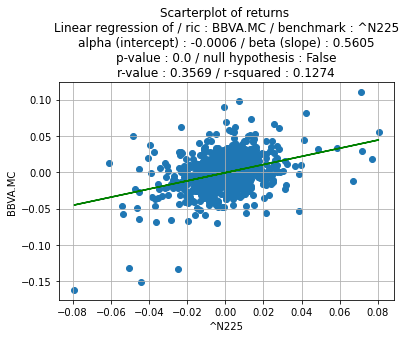

In [7]:
import numpy as np
import pandas as pd
import scipy
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import skew, kurtosis, chi2, linregress
import stream_04_classes_refactoring2
import stream_functions
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


ric = "BBVA.MC"
benchmark = "^N225"
file_extension = "csv"
nb_decimals = 4

# return function
x, y, t = stream_functions.synchronise_timeseries(ric, benchmark, file_extension)

# class lineal regression
capm = capm_manager(ric, benchmark)
capm.load_timeseries()
capm.compute()

# scatterplot of returns
str_title = "Scarterplot of returns " + "\n"\
    + "Linear regression of / ric : " + ric\
    + " / benchmark : " + benchmark + "\n"\
    + "alpha (intercept) : " + str(capm.alpha)\
    + " / beta (slope) : " + str(capm.beta) + "\n"\
    + "p-value : " + str(capm.p_values)\
    + " / null hypothesis : " + str(capm.null_hypothesis) + "\n"\
    + "r-value : " + str(capm.r_values)\
    + " / r-squared : " + str(capm.r_squared)

plt.figure()
plt.title(str_title)
plt.scatter(x,y)
plt.plot(x, capm.predictor_linreg, color="green")
plt.ylabel(ric)
plt.xlabel(benchmark)
plt.grid()
plt.show()

In [8]:
# reset all variables
%reset -f

Voy a crear el método `scatterplot`:

In [9]:
import scipy
import importlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, chi2, linregress


class capm_manager():
    # constructor
    def __init__(self, ric, benchmark):
        self.nb_decimals = 4
        self.ric = ric
        self.benchmark = benchmark
        self.x = []
        self.y = []
        self.t = pd.DataFrame()
        self.beta = 0.0
        self.alpha = 0.0
        self.p_values = 0.0
        self.null_hypothesis = False
        self.r_values = 0.0
        self.r_squared = 0.0
        self.predictor_linreg = []
    
    def load_timeseries(self):
        # load timeseries and syncronise them
        self.x, self.y, self.t = stream_functions.synchronise_timeseries(self.ric, self.benchmark)
    
    def compute(self):
        # linal regression of ric with respect to becnhmark
        slope, intercep, r_values, p_values, std_err = linregress(self.x, self.y)
        self.beta = np.round(slope, self.nb_decimals)
        self.alpha = np.round(intercep, self.nb_decimals)
        self.p_values = np.round(p_values, self.nb_decimals)
        self.null_hypothesis = p_values > 0.05
        self.r_values = np.round(r_values, self.nb_decimals)
        self.r_squared = np.round(r_values**2, self.nb_decimals)
        self.predictor_linreg = self.alpha + self.beta*self.x
    
    def scatterplot(self):
        # scatterplot of returns
        str_title = "Scarterplot of returns " + "\n"\
            + "Linear regression of / ric : " + self.ric\
            + " / benchmark : " + self.benchmark + "\n"\
            + "alpha (intercept) : " + str(self.alpha)\
            + " / beta (slope) : " + str(self.beta) + "\n"\
            + "p-value : " + str(self.p_values)\
            + " / null hypothesis : " + str(self.null_hypothesis) + "\n"\
            + "r-value : " + str(self.r_values)\
            + " / r-squared : " + str(self.r_squared)

        plt.figure()
        plt.title(str_title)
        plt.scatter(self.x,self.y)
        plt.plot(self.x, self.predictor_linreg, color="green")
        plt.ylabel(self.ric)
        plt.xlabel(self.benchmark)
        plt.grid()
        plt.show()

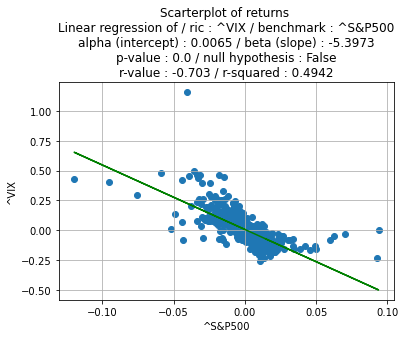

In [10]:
import importlib
import stream_04_classes_refactoring2
import stream_functions
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


ric = "^VIX"
benchmark = "^S&P500"

# return function
x, y, t = stream_functions.synchronise_timeseries(ric, benchmark)

# class lineal regression
capm = capm_manager(ric, benchmark)
capm.load_timeseries()
capm.compute()
capm.scatterplot()

Todas mis variables ahora están encapsuladas en `capm`. Aún así, podemos mejorar el código haciéndolo más limpio, para ello podemos introducir la función de carga de series de tiempo en la clase `capm_manager()`

In [11]:
capm.alpha

0.0065

In [12]:
capm.beta

-5.3973

In [13]:
# reset all variables
%reset -f

Voy a crear mi string de salida para la class capm_manager(): 

* `print(capm)` va a lanzar la función `_str_` de la clase `capm_manager` y me va a regresar el string `str_self`"

In [14]:
import scipy
import importlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, chi2, linregress


class capm_manager():
    # constructor
    def __init__(self, ric, benchmark):
        self.nb_decimals = 4
        self.ric = ric
        self.benchmark = benchmark
        self.x = []
        self.y = []
        self.t = pd.DataFrame()
        self.beta = 0.0
        self.alpha = 0.0
        self.p_values = 0.0
        self.null_hypothesis = False
        self.r_values = 0.0
        self.r_squared = 0.0
        self.predictor_linreg = []
    
    def __str__(self):
        str_self = "Linear regression of | ric : " + self.ric\
            + " | benchmark : " + self.benchmark + "\n"\
            + "alpha (intercept) : " + str(self.alpha)\
            + " | beta (slope) : " + str(self.beta) + "\n"\
            + "p-value : " + str(self.p_values)\
            + " | null hypothesis : " + str(self.null_hypothesis) + "\n"\
            + "r-value : " + str(self.r_values)\
            + " | r-squared : " + str(self.r_squared)
        return str_self
    
    def load_timeseries(self):
        # load timeseries and syncronise them
        self.x, self.y, self.t = stream_functions.synchronise_timeseries(self.ric, self.benchmark)
    
    def compute(self):
        # linal regression of ric with respect to becnhmark
        slope, intercep, r_values, p_values, std_err = linregress(self.x, self.y)
        self.beta = np.round(slope, self.nb_decimals)
        self.alpha = np.round(intercep, self.nb_decimals)
        self.p_values = np.round(p_values, self.nb_decimals)
        self.null_hypothesis = p_values > 0.05
        self.r_values = np.round(r_values, self.nb_decimals)
        self.r_squared = np.round(r_values**2, self.nb_decimals)
        self.predictor_linreg = self.alpha + self.beta*self.x
    
    def scatterplot(self):
        # scatterplot of returns
        str_title = "Scarterplot of returns " + self.__str__()
        plt.figure()
        plt.title(str_title)
        plt.scatter(self.x,self.y)
        plt.plot(self.x, self.predictor_linreg, color="green")
        plt.ylabel(self.ric)
        plt.xlabel(self.benchmark)
        plt.grid()
        plt.show()

In [15]:
import importlib
import stream_04_classes_refactoring2
import stream_functions
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


ric = "^VIX"
benchmark = "^S&P500"

# class lineal regression
capm = capm_manager(ric, benchmark)
capm.load_timeseries()

Si llamo al str de la clase `capm_manager()` sin realizar el `compute` , sólo tengo el string vacío

**LLAMADAS AL \__str\__ SIN COMPUTOS**

In [16]:
print(capm)

Linear regression of | ric : ^VIX | benchmark : ^S&P500
alpha (intercept) : 0.0 | beta (slope) : 0.0
p-value : 0.0 | null hypothesis : False
r-value : 0.0 | r-squared : 0.0


In [17]:
# print(capm) == capm.__str__()
print(capm.__str__())

Linear regression of | ric : ^VIX | benchmark : ^S&P500
alpha (intercept) : 0.0 | beta (slope) : 0.0
p-value : 0.0 | null hypothesis : False
r-value : 0.0 | r-squared : 0.0


**LLAMADA AL \__str\__ LLAMANDO ANTES AL MÉTODO .COMPUTO**

In [18]:
# class lineal regression
capm = capm_manager(ric, benchmark)
capm.load_timeseries()
capm.compute()
print(capm)

Linear regression of | ric : ^VIX | benchmark : ^S&P500
alpha (intercept) : 0.0065 | beta (slope) : -5.3973
p-value : 0.0 | null hypothesis : False
r-value : -0.703 | r-squared : 0.4942


In [19]:
# reset all variables
%reset -f

**`stream_classes.py`**
>
> Cargo la clase `capm_manager()` en el archivo **`stream_classes.py`**

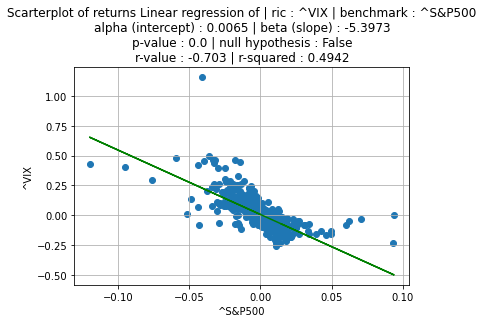

In [20]:
import importlib
import stream_classes
import stream_functions
import stream_04_classes_refactoring2
importlib.reload(stream_classes)
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


ric = "^VIX"
benchmark = "^S&P500"

# class lineal regression
capm = stream_classes.capm_manager(ric, benchmark)
capm.load_timeseries()
capm.compute()
capm.scatterplot()

**GRAFICANDO LA SERIE DE TIEMPO `value Vs market`**  

---

+ Lo haremos de forma normalizada, esto es que comiencen las dos series de tiempo desde 100.

Sabemos que la funcion `synchronise_timeseries()` devuelve la $x,y$ para hacer la regresión lineal y que en la $t$ devuelve el df del precio1 y precio2

In [24]:
ric = "^VIX"
benchmark = "^S&P500"
x, y, t = stream_functions.synchronise_timeseries(ric, benchmark)
t.head(2)

,date,price_1,price_2,return_1,return_2
0,2015-07-02,16.790001,2076.780029,0.043505,-0.000308
1,2015-07-06,17.010000,2068.760010,0.013103,-0.003862


Lo que voy hacer es normalizar estos dos precio1 y precio2. Esto se hace:
* Haré lo mismo para ambas variables
* aislo el `precio1` en sólo una columna `price_ric = t['price_1']`.
* multiplico por 100 toda la columna.
* y lo divido todo por el primero `price_ric[0]`

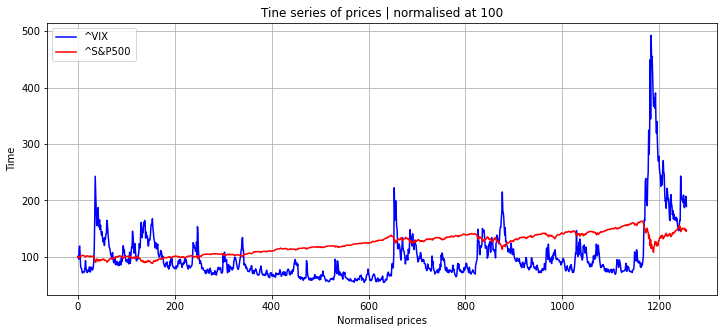

In [25]:
import matplotlib.pyplot as plt

def plot_normalised(t, ric, benchmark):
    """plot 2 timeseries normalised at 100
    """
    price_ric = t['price_1']
    price_benchmark = t['price_2']

    plt.figure(figsize=(12,5))
    plt.title('Tine series of prices | normalised at 100')
    plt.ylabel('Time')
    plt.xlabel('Normalised prices')
    
    price_ric = 100 * price_ric / price_ric[0]
    price_benchmark = 100 * price_benchmark / price_benchmark[0]
    
    plt.plot(price_ric, color='blue', label=ric)
    plt.plot(price_benchmark, color='red', label=benchmark)
    # coloco la leyenda en el 0
    plt.legend(loc=0)
    plt.grid()
    plt.show()

if __name__ == "__main__":
    plot_normalised(t, ric, benchmark)

**QUIERO ESTO COMO MÉTODO EN MI CLASE `capm_manager()`**

In [26]:
import scipy
import importlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, chi2, linregress


class capm_manager():
    # constructor
    def __init__(self, ric, benchmark):
        self.nb_decimals = 4
        self.ric = ric
        self.benchmark = benchmark
        self.x = []
        self.y = []
        self.t = pd.DataFrame()
        self.beta = 0.0
        self.alpha = 0.0
        self.p_values = 0.0
        self.null_hypothesis = False
        self.r_values = 0.0
        self.r_squared = 0.0
        self.predictor_linreg = []
    
    def __str__(self):
        str_self = "Linear regression of | ric : " + self.ric\
            + " | benchmark : " + self.benchmark + "\n"\
            + "alpha (intercept) : " + str(self.alpha)\
            + " | beta (slope) : " + str(self.beta) + "\n"\
            + "p-value : " + str(self.p_values)\
            + " | null hypothesis : " + str(self.null_hypothesis) + "\n"\
            + "r-value : " + str(self.r_values)\
            + " | r-squared : " + str(self.r_squared)
        return str_self
    
    def load_timeseries(self):
        # load timeseries and syncronise them
        self.x, self.y, self.t = stream_functions.synchronise_timeseries(self.ric, self.benchmark)
    
    def compute(self):
        # linal regression of ric with respect to becnhmark
        slope, intercep, r_values, p_values, std_err = linregress(self.x, self.y)
        self.beta = np.round(slope, self.nb_decimals)
        self.alpha = np.round(intercep, self.nb_decimals)
        self.p_values = np.round(p_values, self.nb_decimals)
        self.null_hypothesis = p_values > 0.05
        self.r_values = np.round(r_values, self.nb_decimals)
        self.r_squared = np.round(r_values**2, self.nb_decimals)
        self.predictor_linreg = self.alpha + self.beta*self.x
    
    def scatterplot(self):
        # scatterplot of returns
        str_title = "Scarterplot of returns " + self.__str__()
        plt.figure()
        plt.title(str_title)
        plt.scatter(self.x,self.y)
        plt.plot(self.x, self.predictor_linreg, color="green")
        plt.ylabel(self.ric)
        plt.xlabel(self.benchmark)
        plt.grid()
        plt.show()
    
    def plot_normalised(self):
        # plot 2 timeseries normalised at 100
        price_ric = self.t['price_1']
        price_benchmark = self.t['price_2']

        plt.figure(figsize=(12,5))
        plt.title('Tine series of prices | normalised at 100')
        plt.ylabel('Time')
        plt.xlabel('Normalised prices')

        price_ric = 100 * price_ric / price_ric[0]
        price_benchmark = 100 * price_benchmark / price_benchmark[0]

        plt.plot(price_ric, color='blue', label=self.ric)
        plt.plot(price_benchmark, color='red', label=self.benchmark)
        plt.legend(loc=0)
        plt.grid()
        plt.show

In [27]:
# reset all variables
%reset -f

> Actualizo mi archivo de clases **`stream_classes.py`** añadiendo el método `plot_normalised(self)` que he creado

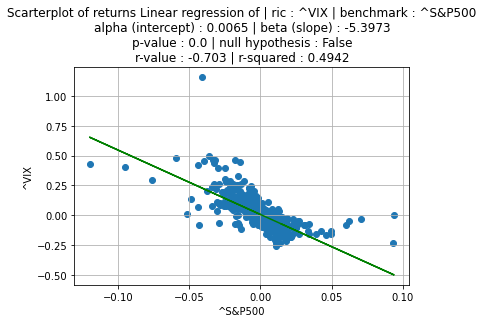

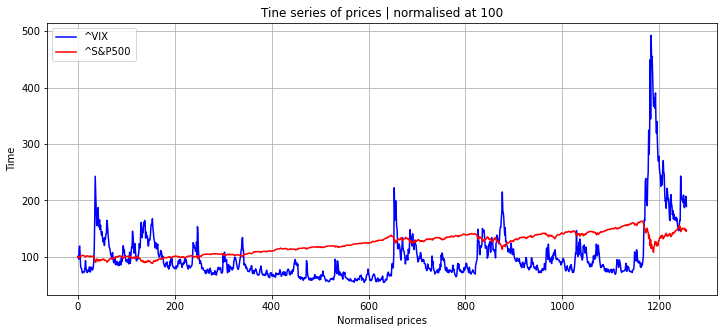

In [28]:
import importlib
import stream_classes
import stream_functions
import stream_04_classes_refactoring2
importlib.reload(stream_classes)
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


ric = "^VIX"
benchmark = "^S&P500"

# class lineal regression
capm = stream_classes.capm_manager(ric, benchmark)
capm.load_timeseries()
capm.compute()
capm.scatterplot()
capm.plot_normalised()

**EL EFECTO DE LA NORMALIZACIÓN EN 100**  
Cuando lo normalizamos y comenzamos en 100 con todos son rendimientos apartir de 100, llegas a ver cláramente que el VIX es mucho más volátil. Podemos ver cláramente que el VIX, siendo el índice de volatilidad del S&P500, los días de mayores caídas para el S&P500 son los momentos de mayores subidas del valor VIX. Esto es el efecto palanca del VIX

¿qué sucede si no normalizamos?

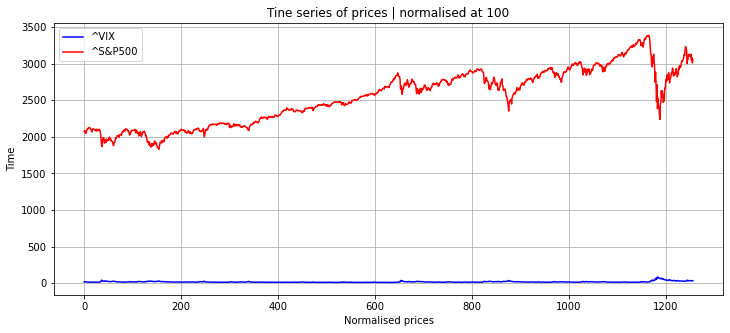

In [29]:
import matplotlib.pyplot as plt

x, y, t = stream_functions.synchronise_timeseries(ric, benchmark)
ric = "^VIX"
benchmark = "^S&P500"

# creo función estática que no depende de clases
def plot_normalised(t, ric, benchmark):
    """plot 2 timeseries normalised at 100
    """
    price_ric = t['price_1']
    price_benchmark = t['price_2']

    plt.figure(figsize=(12,5))
    plt.title('Tine series of prices | normalised at 100')
    plt.ylabel('Time')
    plt.xlabel('Normalised prices')
    
    #price_ric = 100 * price_ric / price_ric[0]
    #price_benchmark = 100 * price_benchmark / price_benchmark[0]
    
    plt.plot(price_ric, color='blue', label=ric)
    plt.plot(price_benchmark, color='red', label=benchmark)
    # coloco la leyenda en el 0
    plt.legend(loc=0)
    plt.grid()
    plt.show()

if __name__ == "__main__":
    plot_normalised(t, ric, benchmark)

> Está claro que no nos daríamos cuenta de la volatilidad del VIX respecto al S&P500, parece que el VIX está plano. **no es la misma escala**.

**PERO.. Y SI LOS VEMOS UNO AL LADO DEL OTRO?**

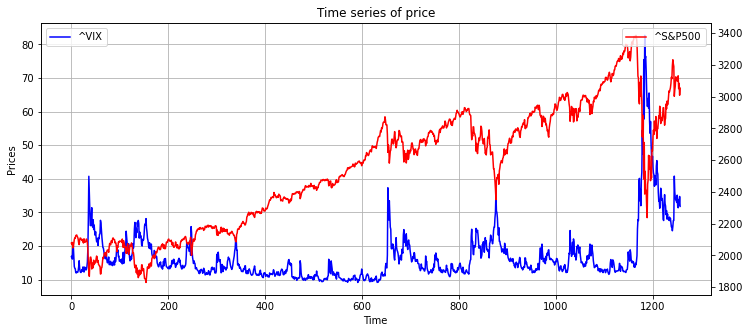

In [30]:
# creo función estática que no depende de clases
def plot_dual_axes(t, ric, benchmark):
    """plot 2 timeseries with 2 vertical axes
    Arguments:
        - t : df 
        - ric : market value
        - benchmark : market
    Return:
        - Plot 2 timeseries
    """
    plt.figure(figsize=(12,5))
    plt.title('Time series of price')
    plt.xlabel('Time')
    plt.ylabel('Prices')
    # considero df de una columna
    ax1 = t['price_1'].plot(color='blue', grid=True, label=ric)
    ax2 = t['price_2'].plot(color='red', grid=True, secondary_y=True, label=benchmark)
    ax1.legend(loc=2)
    ax2.legend(loc=1)
    plt.show()

if __name__ == "__main__":
    ric = "^VIX"
    benchmark = "^S&P500"
    plot_dual_axes(t, ric, benchmark)

In [42]:
import scipy
import importlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, chi2, linregress


class capm_manager():
    # constructor
    def __init__(self, ric, benchmark):
        self.nb_decimals = 4
        self.ric = ric
        self.benchmark = benchmark
        self.x = []
        self.y = []
        self.t = pd.DataFrame()
        self.beta = 0.0
        self.alpha = 0.0
        self.p_values = 0.0
        self.null_hypothesis = False
        self.r_values = 0.0
        self.r_squared = 0.0
        self.predictor_linreg = []
    
    def __str__(self):
        str_self = "Linear regression of | ric : " + self.ric\
            + " | benchmark : " + self.benchmark + "\n"\
            + "alpha (intercept) : " + str(self.alpha)\
            + " | beta (slope) : " + str(self.beta) + "\n"\
            + "p-value : " + str(self.p_values)\
            + " | null hypothesis : " + str(self.null_hypothesis) + "\n"\
            + "r-value : " + str(self.r_values)\
            + " | r-squared : " + str(self.r_squared)
        return str_self
    
    def load_timeseries(self):
        # load timeseries and syncronise them
        self.x, self.y, self.t = stream_functions.synchronise_timeseries(self.ric, self.benchmark)
    
    def compute(self):
        # linal regression of ric with respect to becnhmark
        slope, intercep, r_values, p_values, std_err = linregress(self.x, self.y)
        self.beta = np.round(slope, self.nb_decimals)
        self.alpha = np.round(intercep, self.nb_decimals)
        self.p_values = np.round(p_values, self.nb_decimals)
        self.null_hypothesis = p_values > 0.05
        self.r_values = np.round(r_values, self.nb_decimals)
        self.r_squared = np.round(r_values**2, self.nb_decimals)
        self.predictor_linreg = self.alpha + self.beta*self.x
    
    def scatterplot(self):
        # scatterplot of returns
        str_title = "Scarterplot of returns " + self.__str__()
        plt.figure()
        plt.title(str_title)
        plt.scatter(self.x,self.y)
        plt.plot(self.x, self.predictor_linreg, color="green")
        plt.ylabel(self.ric)
        plt.xlabel(self.benchmark)
        plt.grid()
        plt.show()
    
    def plot_normalised(self):
        # plot 2 timeseries normalised at 100
        price_ric = self.t['price_1']
        price_benchmark = self.t['price_2']

        plt.figure(figsize=(12,5))
        plt.title('Tine series of prices | normalised at 100')
        plt.ylabel('Time')
        plt.xlabel('Normalised prices')

        price_ric = 100 * price_ric / price_ric[0]
        price_benchmark = 100 * price_benchmark / price_benchmark[0]

        plt.plot(price_ric, color='blue', label=self.ric)
        plt.plot(price_benchmark, color='red', label=self.benchmark)
        plt.legend(loc=0)
        plt.grid()
        plt.show
        
    def plot_dual_axes(self):
        # plot 2 timeseries with 2 vertical axes
        plt.figure(figsize=(12,5))
        plt.title('Time series of price')
        plt.xlabel('Time')
        plt.ylabel('Prices')
        # creo un eje horizontal para las dos
        ax = plt.gca()
        # t es un df y uso pandas plot
        ax1 = self.t['price_1'].plot(kind='line',
                                     x='date',
                                     y='price_1',
                                     ax=ax,
                                     color='blue',
                                     grid=True,
                                     label=self.ric)
        ax2 = self.t['price_2'].plot(kind='line',
                                     x='date',
                                     y='price_2',
                                     ax=ax,color='red',
                                     grid=True,
                                     label=self.benchmark,
                                     secondary_y=True)
        ax1.legend(loc=2)
        ax2.legend(loc=1)
        plt.show()

In [43]:
# reset all variables
%reset -f

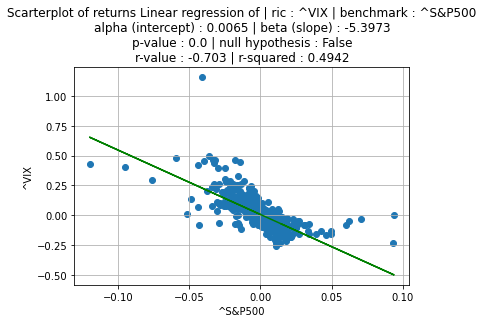

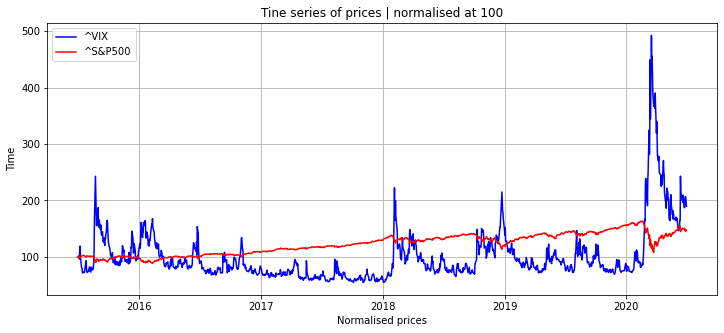

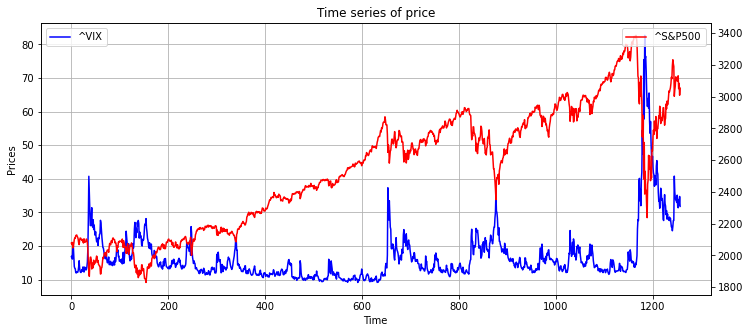

In [44]:
import importlib
import stream_classes
import stream_functions
import stream_04_classes_refactoring2
importlib.reload(stream_classes)
importlib.reload(stream_functions)
importlib.reload(stream_04_classes_refactoring2)


ric = "^VIX"
benchmark = "^S&P500"

# class lineal regression
capm = stream_classes.capm_manager(ric, benchmark)

capm.load_timeseries()
capm.compute()
capm.scatterplot()
capm.plot_normalised()
capm.plot_dual_axes()

Esta última escala me gusta porque vemos cláramente que cuando cae el precio del S&P500 la volatilidad explota

* Del lado izquierdo : tengo la escala del `VIX`
* Del lado derecho tengo la escala del `S&P500`

Viendo estás gráficas podemos decor que el `beta` es negativo y ha de ser un beta muy grande, y es exáctamente lo que nos da en datos el string de la regresion lineal.

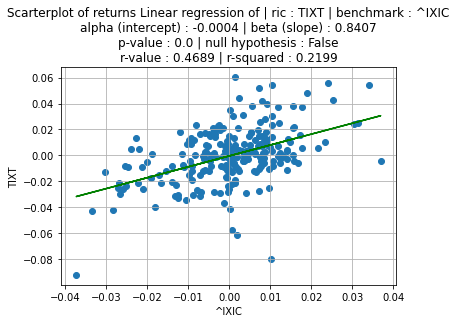

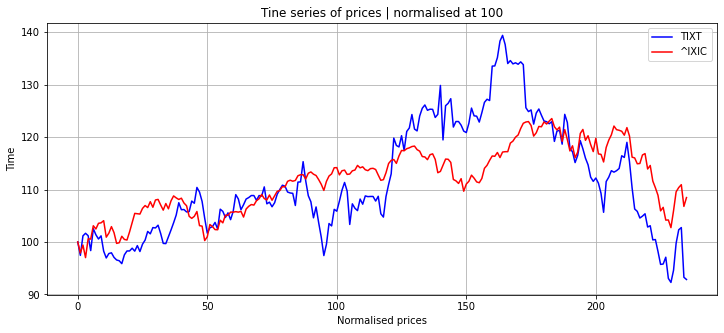

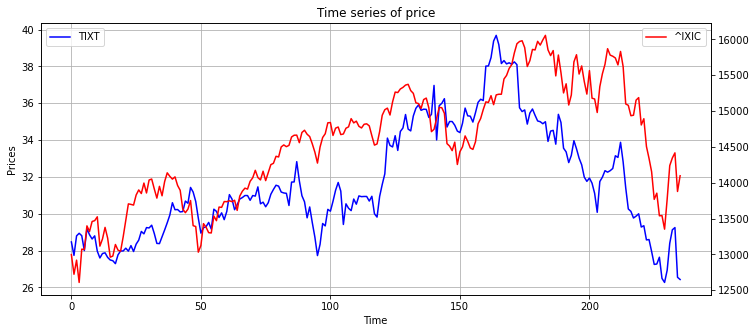

Linear regression of | ric : TIXT | benchmark : ^IXIC
alpha (intercept) : -0.0004 | beta (slope) : 0.8407
p-value : 0.0 | null hypothesis : False
r-value : 0.4689 | r-squared : 0.2199


In [41]:
import importlib
import stream_functions
importlib.reload(stream_functions)  # aveces no importa bien

ric = "TIXT"
benchmark = "^IXIC" # == ^NASDAQ

capm = stream_classes.capm_manager(ric, benchmark)
capm.load_timeseries()
capm.compute()
capm.scatterplot()
capm.plot_normalised()
capm.plot_dual_axes()
print(capm)

La correlación es del 46.89%

---

**VOY A MODIFICAR MI CLASE Jarque-Bera en `stream_classes.py`**  
> La idea es pensar en el programador usuario que va a utilizar el código pero sin saber cómo se construye cada clase. Simplemente sabrá para qué se usa cada clase y la ejecutaré de forma limpia. Para ello será más cómodo que escondamos la función de caraga de datos de series de tiempo y esas variables sea utilizadas dentro de la clase.

Original:

In [21]:
class jarque_bera_test():

    def __init__(self, x, x_str):
        # create constructor
        self.returns = x
        self.str_name = x_str
        self.size = len(x)  # size of returns
        self.round_digit = 5  # por si quiero modificarlo
        self.mean = 0.0
        self.stdev = 0.0
        self.skew = 0.0
        self.kurt = 0.0
        self.sharpe = 0.0
        self.median = 0.0
        self.var_95 = 0.0
        self.cvar_95 = 0.0
        self.jarque_bera = 0.0
        self.p_value = 0.0
        self.is_normal = 0.0

    def compute(self):
        # compute "risk metrics"
        self.mean = np.mean(self.returns)
        self.stdev = np.std(self.returns)
        self.skew = skew(self.returns)
        self.kurt = kurtosis(self.returns)
        self.sharpe = self.mean / self.stdev * np.sqrt(252)
        self.median = np.median(self.returns)
        self.var_95 = np.percentile(self.returns, 5)
        self.cvar_95 = np.mean(self.returns[self.returns <= self.var_95])
        self.jarque_bera = self.size/6 * (
            self.skew**2 + 1/4*(self.kurt**2)
        )
        self.p_value = 1 - chi2.cdf(self.jarque_bera, df=2)
        self.is_normal = (self.p_value > 0.05)  # equivalenty jb < 6

    def __str__(self):
        str_self = self.str_name + " | size " + str(self.size) + \
                   "\n" + self.plot_str() + "\n"
        return str_self

    def plot_str(self):
        plot_str = "mean: " + str(np.round(self.mean, self.round_digit))\
            + " | std : " + str(np.round(self.stdev, self.round_digit))\
            + " | skewness : " + str(np.round(self.skew, self.round_digit))\
            + " | kurtosis : " + str(np.round(self.kurt, self.round_digit))\
            + " | median : " + str(np.round(self.median, self.round_digit))\
            + " | x_sharpe ratio :" + str(np.round(self.sharpe, 4)) + "\n"\
            + " VaR 95% : " + str(np.round(self.var_95, 4))\
            + " | CVaR 95% : " + str(np.round(self.cvar_95, self.round_digit))\
            + " | Jarque-Bera : " + str(np.round(self.jarque_bera, self.round_digit))\
            + " | p_value : " + str(np.round(self.p_value, self.round_digit))\
            + " | is normal :" + str(self.is_normal)
        return plot_str

> Modificación:
>
> Voy a introducir un método nuevo en la clase que me carga los datos de la serie de tiempo. Así cuando llamo al \__main\__ no hace falta llamar a la función `stream.load_tiem series(ric)`, esta carga quedará encapsulada.
>
> También voy a introducir las funciones:
> * **`stream_functions`**.plot_time_series_price(jb.ric, jb.t)`  
> * **`stream_functions`**.plot_histogram(jb.returns, jb.str_name, jb.plot_str())`  
>
> Dentro de la clase.

In [22]:
# !/usr/bin/ python
# -*- coding: utf-8 -*-

import scipy
import importlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, chi2, linregress
# load our own file
import stream_functions
importlib.reload(stream_functions)


class jarque_bera_test():

    def __init__(self, ric):
        # create constructor
        self.ric = ric
        self.returns = []
        self.size = 0
        self.str_name = None
        self.mean = 0.0
        self.stdev = 0.0
        self.skew = 0.0
        self.kurt = 0.0
        self.sharpe = 0.0
        self.median = 0.0
        self.var_95 = 0.0
        self.cvar_95 = 0.0
        self.jarque_bera = 0.0
        self.p_value = 0.0
        self.is_normal = 0.0
        self.round_digit = 4
    
    def __str__(self):
        str_self = self.str_name + " | size " + str(self.size) + \
                   "\n" + self.plot_str() + "\n"
        return str_self

    def load_timeseries(self):
        self.returns, self.str_name, self.t = stream_functions.load_time_series(self.ric)
        self.size = self.t.shape[0]

    def compute(self):
        # compute "risk metrics"
        self.size = self.t.shape[0]
        self.mean = np.mean(self.returns)
        self.stdev = np.std(self.returns)
        self.skew = skew(self.returns)
        self.kurt = kurtosis(self.returns)
        self.sharpe = self.mean / self.stdev * np.sqrt(252)
        self.median = np.median(self.returns)
        self.var_95 = np.percentile(self.returns, 5)
        self.cvar_95 = np.mean(self.returns[self.returns <= self.var_95])
        self.jarque_bera = self.size/6 * (
            self.skew**2 + 1/4*(self.kurt**2)
        )
        self.p_value = 1 - chi2.cdf(self.jarque_bera, df=2)
        self.is_normal = (self.p_value > 0.05)  # equivalenty jb < 6

    def plot_str(self):
        plot_str = "mean: " + str(np.round(self.mean, self.round_digit))\
            + " | std : " + str(np.round(self.stdev, self.round_digit))\
            + " | skewness : " + str(np.round(self.skew, self.round_digit))\
            + " | kurtosis : " + str(np.round(self.kurt, self.round_digit))\
            + " | median : " + str(np.round(self.median, self.round_digit))\
            + " | x_sharpe ratio :" + str(np.round(self.sharpe, 4)) + "\n"\
            + " VaR 95% : " + str(np.round(self.var_95, 4))\
            + " | CVaR 95% : " + str(np.round(self.cvar_95, self.round_digit))\
            + " | Jarque-Bera : " + str(np.round(self.jarque_bera, self.round_digit))\
            + " | p_value : " + str(np.round(self.p_value, self.round_digit))\
            + " | is normal :" + str(self.is_normal)
        return plot_str
    
    def plot_timeseries(self):
        """Plot series time from data markets
        Arguments:
           -ric : cod  
           -t :  dataframe
        """
        plt.figure()
        plt.plot(self.t["date"], self.t["close"])
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.title("tiem series real price " + self.ric)

    def plot_histogram(self):
        """Plot histogram from data markets
        Arguments:
           -x : cod  
           -x_str : dataframe
           -str1 : print risk metrics
           -str2 : print risk metrics
        """
        self.bins=100
        plt.figure()
        plt.hist(self.returns, self.bins)
        plt.title("Histrogram " + self.str_name)
        plt.xlabel(self.plot_str())
        plt.show()

> Entonces el usuario realizará sólo estas llamdas de forma sencilla:

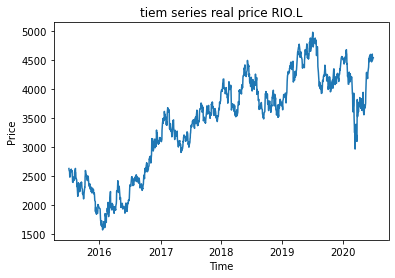

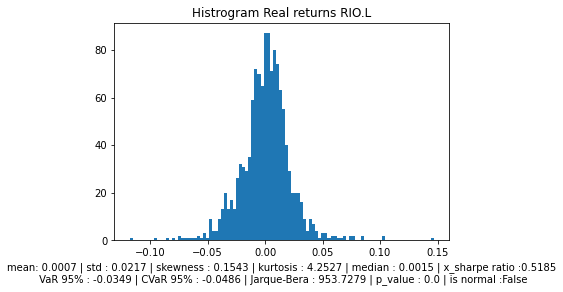

Real returns RIO.L | size 1259
mean: 0.0007 | std : 0.0217 | skewness : 0.1543 | kurtosis : 4.2527 | median : 0.0015 | x_sharpe ratio :0.5185
 VaR 95% : -0.0349 | CVaR 95% : -0.0486 | Jarque-Bera : 953.7279 | p_value : 0.0 | is normal :False



In [45]:
import importlib
import stream_classes
importlib.reload(stream_classes)


ric = "RIO.L"
# compute risk metrics for real returns
jb = stream_classes.jarque_bera_test(ric)  # create object of class
jb.load_timeseries()                       # load from load_timeseries() method
jb.compute()                               # compute from compute() method
jb.plot_timeseries()                       # plot from plot_timeseries() method
jb.plot_histogram()                        # plot from plot_histogram() method
print(jb)                                  # print __str__() method